# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name: Xiaotong

Last Name: Wang

Student ID: 913738935

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [45]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

conn3 = sqlite3.connect("sf_data.sqlite")
#c = conn3.cursor()
mobile_food_locations = pd.read_sql_query('select * from mobile_food_locations', conn3)
#select the Longtitude data from mobile_food_locations
mobile_food_locations.head()


#c.execute("PRAGMA table_info('mobile_food_locations')")
#c.execute("PRAGMA table_info('mobile_food_permits')")

,locationid,LocationDescription,Address,Latitude,Longitude
0,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532
1,437211,MISSOURI ST: 20TH ST to SIERRA ST (500 - 630),555 MISSOURI ST,37.759304,-122.395902
2,765880,17TH ST: SAN BRUNO AVE to UTAH ST (2200 - 2299),2222 17TH ST,37.765216,-122.406007
3,765690,CESAR CHAVEZ ST: EVANS AVE to KANSAS ST (2100 ...,2323 CESAR CHAVEZ ST,37.748801,-122.400552
4,751253,FOLSOM ST: 14TH ST to 15TH ST (1800 - 1899),1800 FOLSOM ST,37.767852,-122.416105


In [2]:
# conn3 = sqlite3.connect("sf_data.sqlite")
# c = conn3.cursor()
# c.execute("""select * from mobile_food_locations""")
# c.fetchone()

In [3]:
mobile_food_permits = pd.read_sql_query('select * from mobile_food_permits', conn3)
#select the data from mobile_food_permits
mobile_food_permits.head()

,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,16MFF-0027,APPROVED,F & C Catering,Truck,Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...,1,2016-03-09 12:00:00,2017-03-15 12:00:00
1,13MFF-0102,EXPIRED,Natan's Catering,Truck,Burgers: melts: hot dogs: burritos:sandwiches:...,1,2013-04-12 12:00:00,2014-03-15 12:00:00
2,16MFF-0069,APPROVED,Munch A Bunch,Truck,Cold Truck: packaged sandwiches: pitas: breakf...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
3,16MFF-0051,APPROVED,Park's Catering,Truck,Cold Truck: Hamburger: cheeseburgers: hot dogs...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
4,16MFF-0010,REQUESTED,Pipo's Grill,Truck,Tacos: Burritos: Hot Dogs: and Hamburgers,0,None,None


In [4]:
mobile_food_schedule = pd.read_sql_query('select * from mobile_food_schedule', conn3)
#select the data from mobile_food_permits
mobile_food_schedule.head()

,locationid,permit,DayOfWeek,EndHour,StartHour
0,305727,11MFF-0040,Mo,15,10
1,305727,11MFF-0040,Tu,15,10
2,305727,11MFF-0040,We,15,10
3,305727,11MFF-0040,Th,15,10
4,305727,11MFF-0040,Fr,15,10


In [5]:
sql_query = """ 
SELECT Applicant, mobile_food_permits.permit, count(DISTINCT locationid) as loc_count from mobile_food_permits
INNER JOIN mobile_food_schedule
ON mobile_food_permits.permit = mobile_food_schedule.permit
GROUP BY Applicant
order by loc_count desc
"""
food_sells = pd.read_sql_query(sql_query,conn3)
food_sells.head()

,Applicant,permit,loc_count
0,May Catering,17MFF-0110,58
1,Anas Goodies Catering,17MFF-0111,37
2,Natan's Catering,13MFF-0102,37
3,Liang Bai Ping,17MFF-0090,33
4,Park's Catering,16MFF-0051,23


In [6]:
Approved_sql_query = """ 
SELECT Applicant, mobile_food_permits.permit, Status, count(DISTINCT locationid) as loc_count from mobile_food_permits
INNER JOIN mobile_food_schedule
ON mobile_food_permits.permit = mobile_food_schedule.permit
WHERE Status = 'APPROVED'
GROUP BY Applicant
order by loc_count desc
"""
Approved_food_sells = pd.read_sql_query(Approved_sql_query,conn3)
Approved_food_sells.head()

,Applicant,permit,Status,loc_count
0,Park's Catering,16MFF-0051,APPROVED,23
1,D & T Catering,16MFF-0037,APPROVED,17
2,F & C Catering,16MFF-0027,APPROVED,13
3,Munch A Bunch,16MFF-0069,APPROVED,10
4,Eva's Catering,16MFF-0055,APPROVED,8


From above, I connected the mobile_food_permits and mobile_food_schedule, based all the data, the mobile food vendor(s) sells at the most locations is May Catering, the count is 58. And then I selected the data by status which is APPROVED the mobile food vendor(s) sells at the most locations is Park's Catering, the count is 23

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

Question1: Which parts of the city are the most and least expensive?

    RegionName     avg_sold   avg_rent
0        94124   342.662839  14.332667
1        94134   423.088712  16.680556
2        94102   771.767609  16.716364
3        94103   772.299804  17.796136
4        94112   522.153170  17.959275
5        94080   437.614029  18.237391
6        94107   803.935067  18.955143
7        94109   812.247147  19.200476
8        94132   465.239814  19.487692
9        94105   988.497131  20.340000
10       94158  1120.358515  20.340000
11       94110   782.967110  20.994030
12       94133   882.532721  21.103333
13       94116   608.916248  21.262131
14       94122   602.991759  21.407213
15       94115   828.418343  21.510893
16       94117   805.164085  21.958704
17       94131   760.421617  22.823594
18       94121   645.045985  23.039783
19       94127   657.288167  23.671556
20       94114   902.418815  23.987692
21       94123   987.337775  26.391944


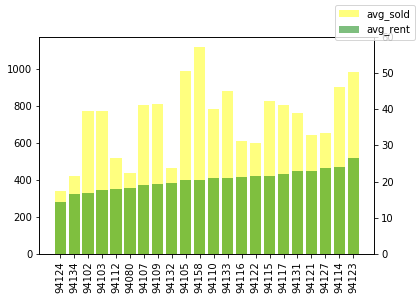

In [94]:
zillow = pd.read_sql_query('select * from zillow', conn3)

zillow_sql_query = """
SELECT RegionName, AVG(MedianSoldPricePerSqft_AllHomes) as avg_sold, AVG(PriceToRentRatio_AllHomes) as avg_rent from zillow 
WHERE MedianSoldPricePerSqft_AllHomes and PriceToRentRatio_AllHomes IS NOT Null
GROUP BY RegionName
ORDER BY avg_rent
"""
zillow_data = pd.read_sql_query(zillow_sql_query,conn3)
print(zillow_data)

fig, ax = plt.subplots()
ax2 = ax.twinx()

x = range(len(zillow_data['RegionName']))
ax.set_xticks(x)
ax.set_xticklabels(zillow_data['RegionName'], rotation = 'vertical', size = 10)
ax2.set_ylim(0,60)
ax.bar(x, zillow_data['avg_sold'],color = 'yellow', alpha = 0.5, label = 'avg_sold')
ax2.bar(x, zillow_data['avg_rent'], color = 'green', alpha = 0.5, label = 'avg_rent')
fig.legend()
plt.show()
# plt.hist(zillow_data['RegionName'], zillow_data['avg_sold'], alpha=0.3,label='avg_sold')
# plt.hist(zillow_data['RegionName'], zillow_data['avg_rent'], alpha=0.3,label='avg_rent')
# plt.xlabel(zillow_data['RegionName'])
# plt.legend()
# plt.show()